#  Deploying  model on a SageMaker Endpoint and visualize predictions

## 1 - Setup environment

In [2]:
import cv2
import sagemaker
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.tensorflow import TensorFlowModel
import visualization_utils as viz_utils

role = sagemaker.get_execution_role()
#model artifacts path
model_artefact = 's3://sagemaker-us-west-2-743025358310/tf2-object-detection-2021-06-18-02-41-00-395/output/model.tar.gz'
sess = sagemaker.Session()

## 2 - Create endpoint

In [3]:
model = TensorFlowModel(
    name=name_from_base('tf2-object-detection'),
    model_data=model_artefact,
    role=role,
    framework_version='2.2'
)

In [4]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [5]:
# endpoint_name3 = '<endpoint name>'
# predictor = sagemaker.predictor.Predictor(endpoint_name = endpoint_name3,sagemaker_session = sess)
print(predictor)

## 3 - Predict Single Image

In [6]:
def image_file_to_tensor(path):
    cv_img = cv2.imread(path,1).astype('uint8')
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return cv_img

In [26]:
img = image_file_to_tensor('test_images/t19.jpeg')
input = {
  'instances': [img.tolist()]
}

detections = predictor.predict(input)['predictions'][0]
img_with_detections = img.copy()
category_index = {1:{'id': 1, 'name': 'Coconut Oil'},
                  2:{'id': 2, 'name': 'Face Wash'},
                  3:{'id': 3, 'name': 'LED'},
                  4:{'id': 4, 'name': 'Parle-G'},
                  5:{'id': 5, 'name': 'Soap'},
                  6:{'id': 6, 'name': 'Tea'},
                  7:{'id': 7, 'name': 'Vicks'}}
detection_boxes = np.array(detections['detection_boxes'])
detection_classes = [int(x) for x in detections['detection_classes']]
detection_scores = detections['detection_scores']

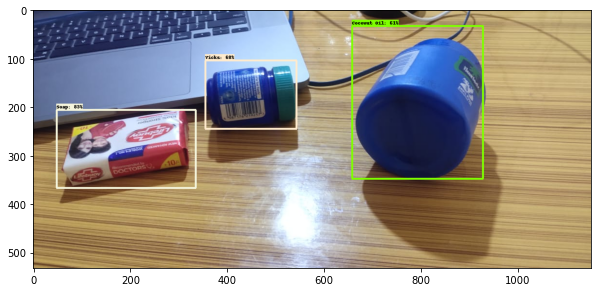

In [22]:
%matplotlib inline

viz_utils.visualize_boxes_and_labels_on_image_array(
    img_with_detections,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=10,
    min_score_thresh=0.60,
    agnostic_mode=False)

plt.figure(figsize=(10,50))
plt.imshow(img_with_detections)
plt.show()

## 4 - Predicting Whole Directory

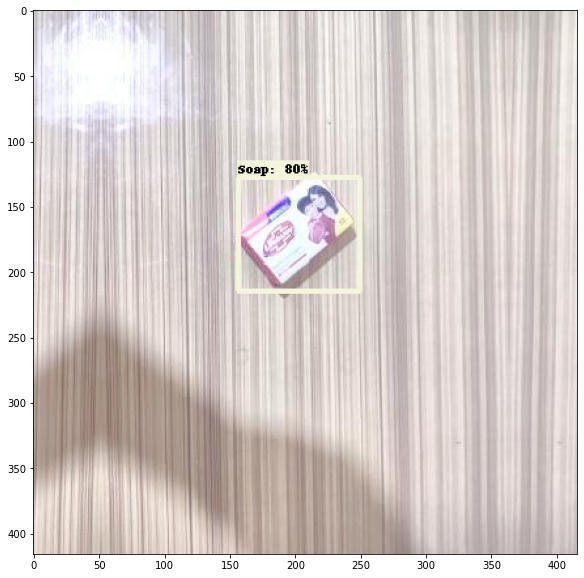

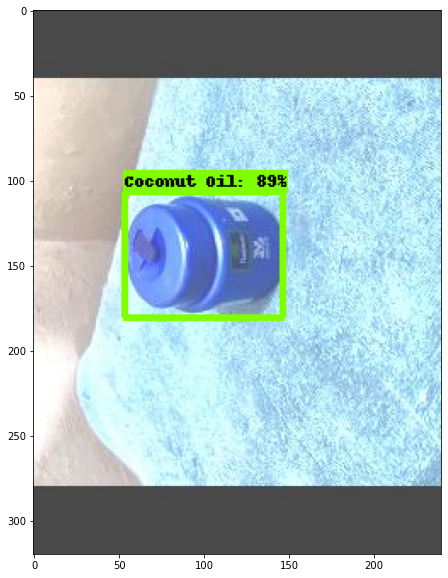

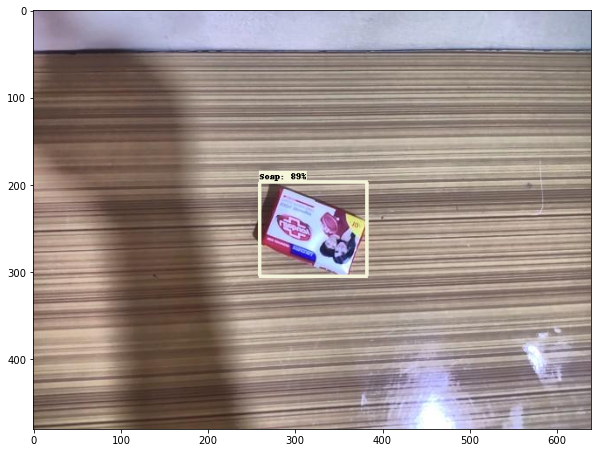

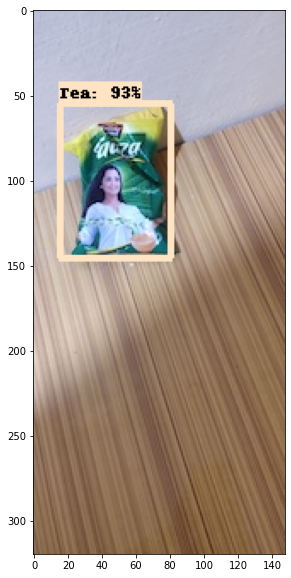

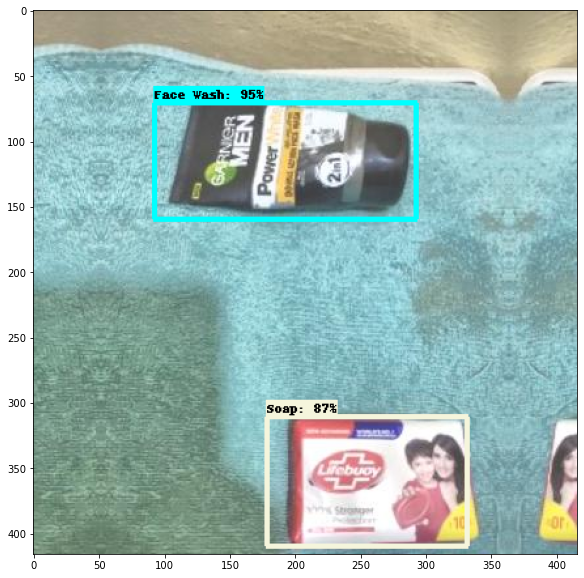

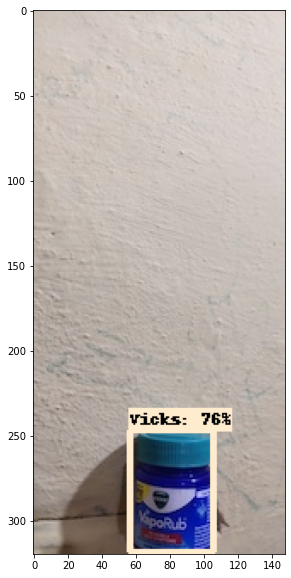

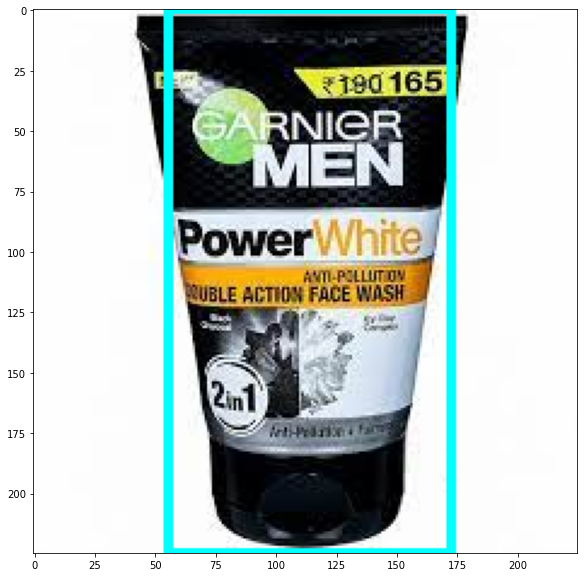

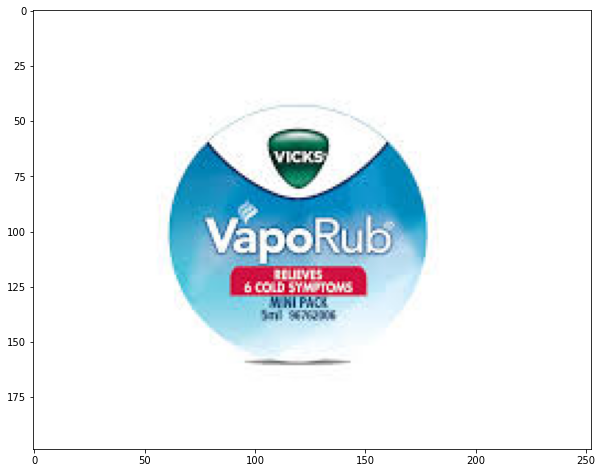

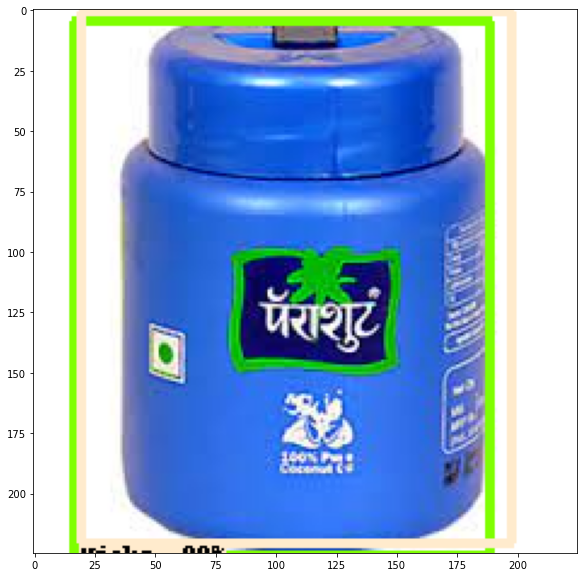

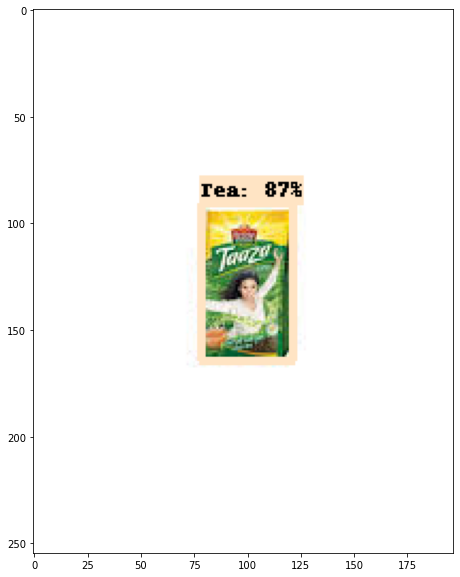

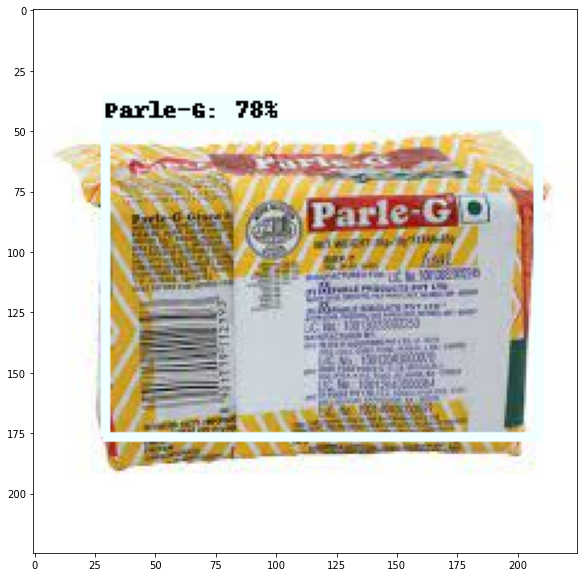

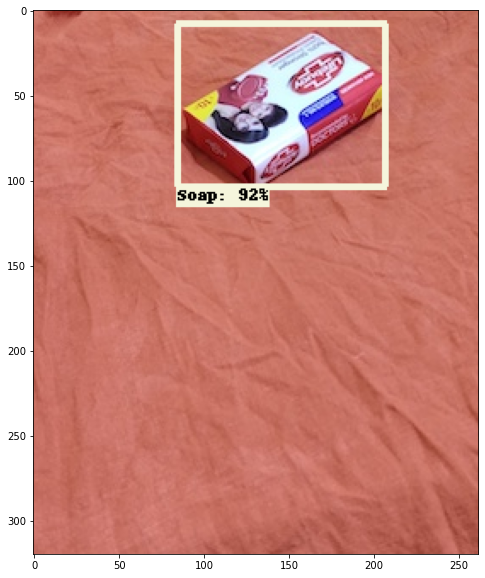

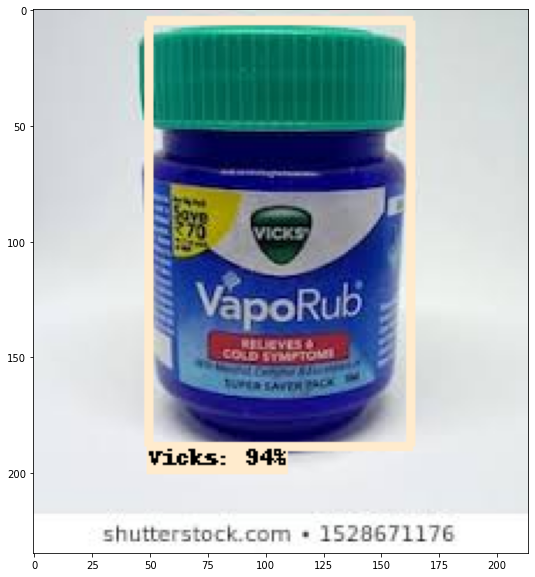

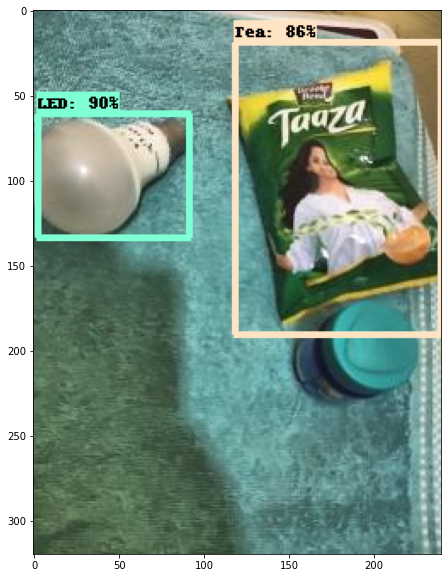

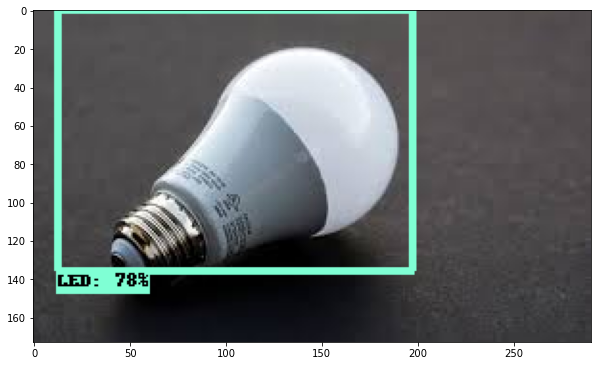

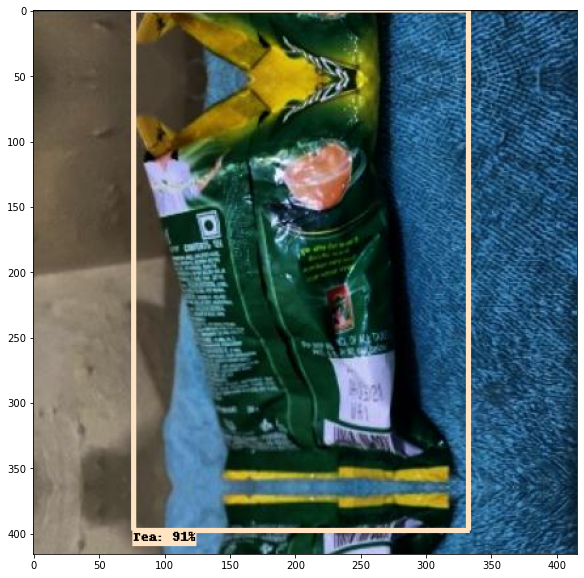

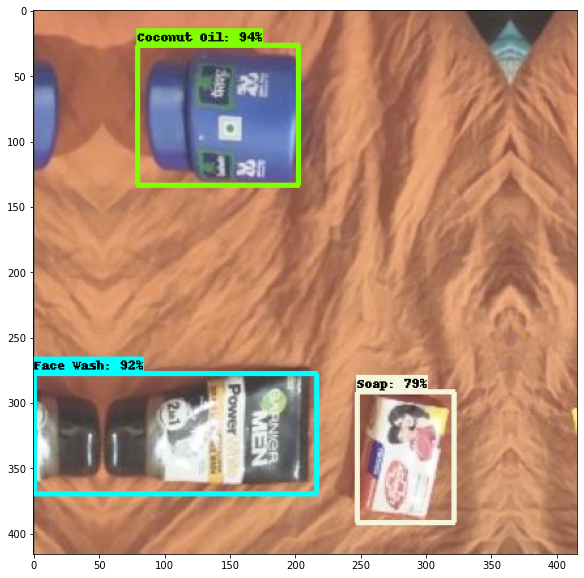

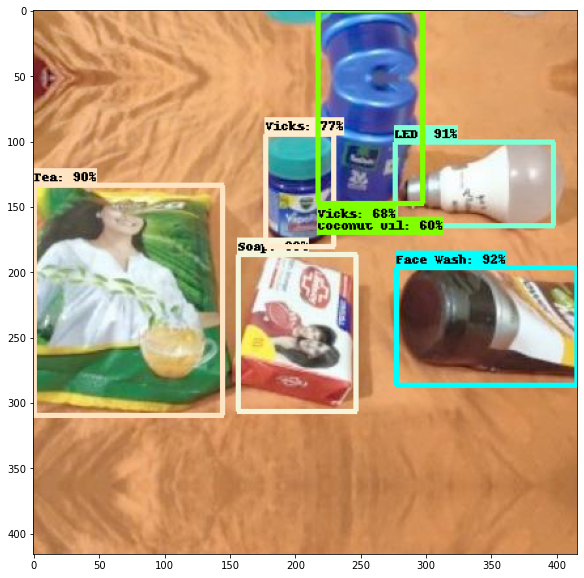

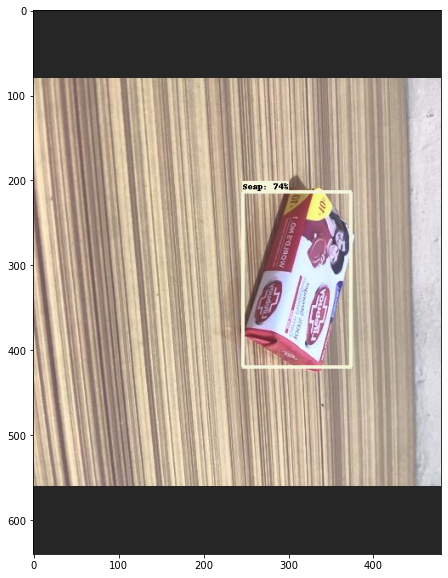

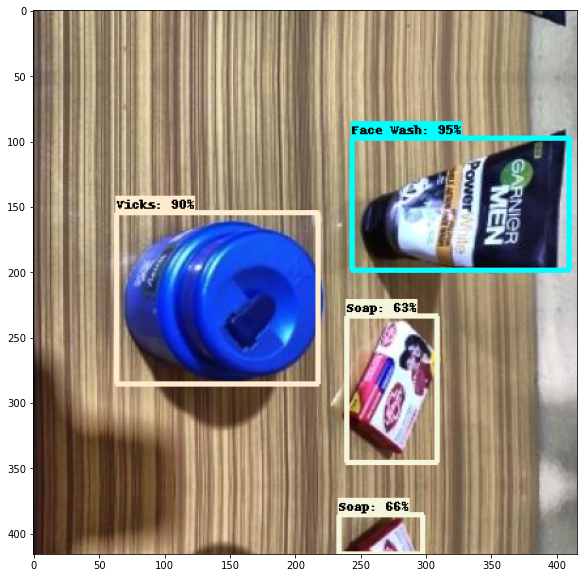

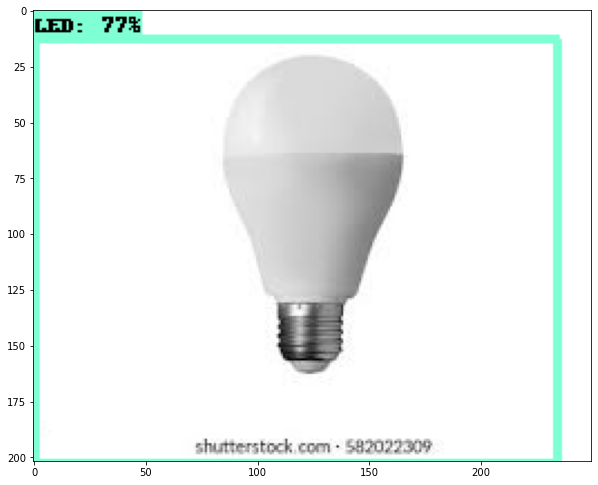

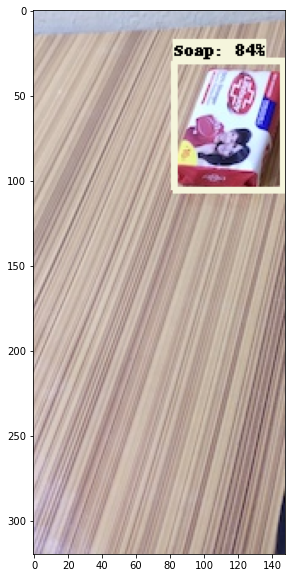

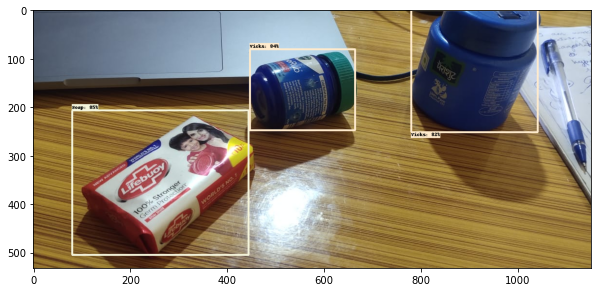

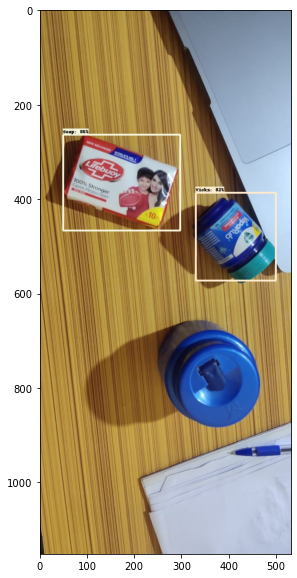

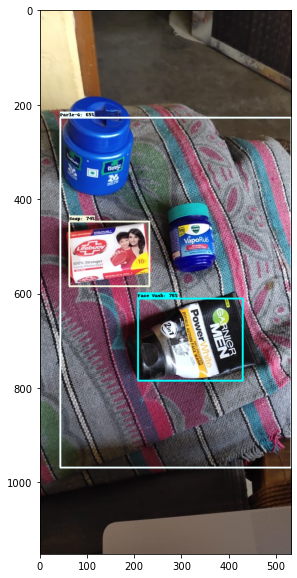

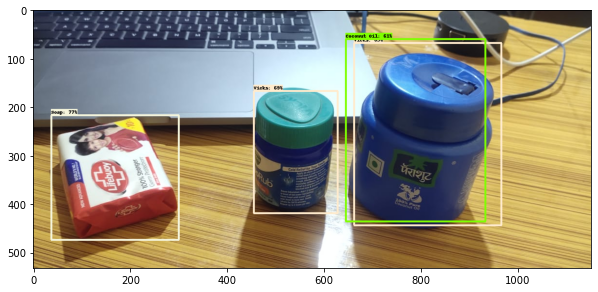

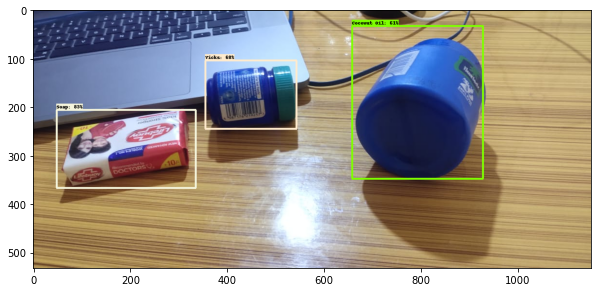

In [24]:
import json
import glob
imdir = 'test_images/'
ext = ['jpg','jpeg',]    # Add image formats here

files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
category_index = {1:{'id': 1, 'name': 'Coconut Oil'},
                  2:{'id': 2, 'name': 'Face Wash'},
                  3:{'id': 3, 'name': 'LED'},
                  4:{'id': 4, 'name': 'Parle-G'},
                  5:{'id': 5, 'name': 'Soap'},
                  6:{'id': 6, 'name': 'Tea'},
                  7:{'id': 7, 'name': 'Vicks'}}


for file in files:
    img = image_file_to_tensor(file)
    input = {
      'instances': [img.tolist()]
    }
    detections = predictor.predict(input)['predictions'][0]
    img_with_detections = img.copy()
    detection_boxes = np.array(detections['detection_boxes'])
    detection_classes = [int(x) for x in detections['detection_classes']]
    detection_scores = detections['detection_scores']
    
    %matplotlib inline

    viz_utils.visualize_boxes_and_labels_on_image_array(
        img_with_detections,
        detection_boxes,
        detection_classes,
        detection_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=10,
        min_score_thresh=0.60,
        agnostic_mode=False)

    plt.figure(figsize=(10,10))
    plt.imshow(img_with_detections)
    plt.show()
    

## 5 - Delete endpoint

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)